<h1> Implémentation du schéma de Rusanov - CAS 2D </h1>

Voici le code à partir duquel nous avons obtenu les graphes du rapport. Ce code permet aussi de générer des fichier .gif et ainsi de visualiser les évolutions (hauteur d'eau et débit) au cours du temps.

<h2>Équations dans le cas 2D :</h2>

$$ \frac{\partial h}{\partial t} + \frac{\partial hu}{\partial x} + \frac{\partial hv}{\partial y} = 0$$

$$ \frac{\partial hu}{\partial t} + \frac{\partial}{\partial x} ( hu^2 + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( huv ) = 0$$

$$ \frac{\partial hv}{\partial t} + \frac{\partial}{\partial x} ( huv ) + \frac{\partial}{\partial y} ( hv^2 + \frac{gh^2}{2} ) = 0$$

## Importations

In [1]:
import math as math # Pour les fonctions math

import matplotlib.pyplot as plt # Pour l'affichage des graphes
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib import cm
from mpl_toolkits import mplot3d 

plt.rc('font', size=20)

import numpy as np # Pour les tableaux numpy
import imageio # Pour faire des .gif

## Paramètres du problème

In [19]:
g=1 # Constante gravitationnelle

xMin=0 # Bord gauche du domaine
xMax=100 # Bord droit du domaine

yMin = 0 #Bord bas du domaine
yMax = 100 #Bord haut du domaine

N = 128 # Nombre de points (strictement à l'intérieur)
# Donc au total, on considère (N+2)^2 points avec les bords

h=(xMax-xMin)/(N+1) # Pas du maillage spatial, le même pour X et Y

Tmax = 50 # Temps final de la simulation
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

## Conditions initiales et Topographie

Dans la cellule ci-dessous, nous définissons la discrétisation de l'axe des abscisses $\textbf{X}$, ainsi que la topographie $\textbf{Z}$ et les profils initiaux de la hauteur d'eau $h$ et des débits $hu$ et $hv$ selon $x$ et $y$ respectivement. Le code en commentaire correspond à différentes initialisations possibles. Pour le suite, notons 
$\textbf{W}=
\begin{pmatrix}
   h \\
   hu \\
   hv \\
\end{pmatrix}
\in\mathbb{R}^{3}$ 
le vecteur inconnu.

In [20]:
X,Y=np.mgrid[xMin:xMax+2*h/3:h,yMin:yMax+2*h/3:h] # Discrétisation de [xMin, xMax] et [yMin, yMax]


W = np.ones([N+2,N+2,3]) # Discrétisation de h , hu et hv
Wprime = np.ones([N+2,N+2,3]) # Pour les calculs dans la boucle temporelle


#Pour améliorer la complexité de l'algorithme
Tableau_F_Ronde = np.ones([N+2,N+2,3])
Tableau_G_Ronde = np.ones([N+2,N+2,3])



# Définitions du h initial ------------------------------------

# Hauteur de l'eau en escalier 
W[0:(N+2)//3,0:(N+2)//3,0]   = 3

# Hauteur de l'eau constante
# W[:,:,0]=1

# Hauteur de l'eau en bosse
# W = 2+10/(4 + .01*( (X-50)**2 + (Y-50)**2 ) )

# Hauteur de l'eau en double bosse
# W[:,:,0] = 2+1/np.cosh(np.sqrt((X-25)**2+(Y-50)**2))
# W[:,:,0] += 1/np.cosh(np.sqrt((X-75)**2+(Y-50)**2))


# Définitions des débit initial ------------------------------------

# Débit de l'eau constant
W[:,:,1]=0
W[:,:,2]=0

## Nombre de sauvegardes durant la simulation

Quelques variables qui vont nous servir pour enregistrer des étapes de la simulation, sans pour autant les sauvegarder toutes. Sans ça, le nombre d'images à sauver deviendrait vite trop important. De plus, l'affichage ne serait pas uniforme dans le temps car certains passages de la simulation nécessitent des pas de temps plus petits.

In [21]:
nSauvegarde=100 # Nombre de sauvegardes au cours de la simulation
tSauvegarde=[False for i in range(nSauvegarde)]

imageH=[]
imageHU=[]
imageHV=[]

k=0 # Nombre de sauvegardes déjà effectuées

## Affichage des images

La fonction ci-dessous permet de gérer l'affichage de la solution. Elle est suivie d'un test. Les graphes qui s'affichent sont ceux de $h$ et $q$ à $t=0$.

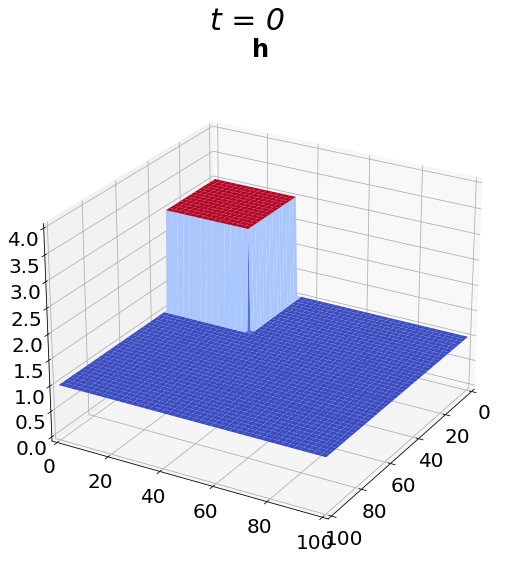

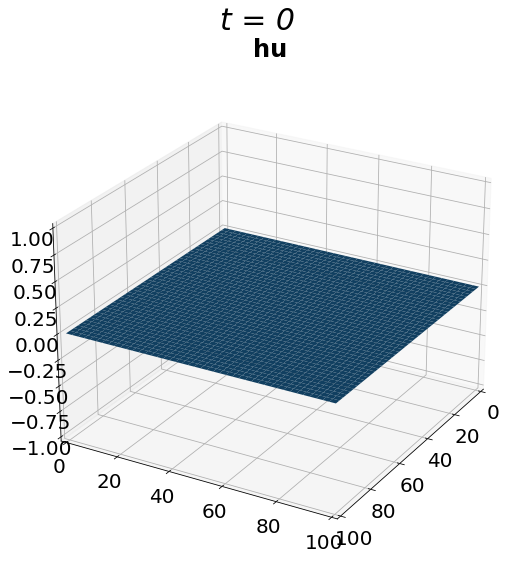

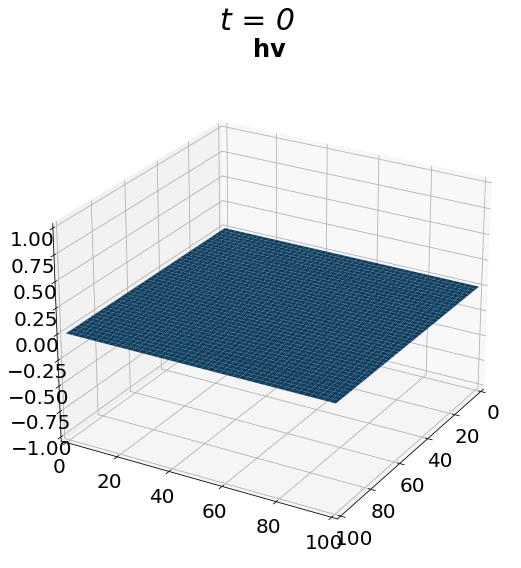

In [22]:
def affiche_W(t=0,index=0):
    
    #index : suivant que l'on veuille afficher h, hu ou hv
    
    t_int=round(t,4) # Troncature de t après la 4eme décimale
    
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W[:,:,0], cmap=cm.coolwarm) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W[:,:,1])
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W[:,:,2])
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
    
    ax.view_init(25, 30)
    
    plt.show()
    
#Affichage de h, u et v
affiche_W()
affiche_W(index=1)
affiche_W(index=2)

## Sauvegarde des images

_enregistre_W_ effectue un traitement identique à _affiche_W_. La seule différence est qu'elle enregistre le plot dans le répertoire courant plutôt que de l'afficher.

In [23]:
def enregistre_W(t,index=0):

    t_int=round(t,4) # Troncature de t après la 4eme décimale
      
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W[:,:,0], cmap=cm.coolwarm) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W[:,:,1])
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W[:,:,2])
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
 
    ax.view_init(25,30)
    
    fig.canvas.draw()
    image_from_plot=np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot=image_from_plot.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    
    if(index==0):
        imageH.append(image_from_plot)
    elif(index==1):
        imageHU.append(image_from_plot)
    elif(index==2):
        imageHV.append(image_from_plot)
    
    plt.close()
    
enregistre_W(0,index=0)
enregistre_W(0,index=1)
enregistre_W(0,index=2)

<h2> Fonctions intervenant dans le schéma </h2>

En posant : $W = \left[ {\begin{array}{c}   h \\    hu \\    hv \\  \end{array} } \right] $ ; $ F(W) = \left[ {\begin{array}{c}   hu \\    hu^2 + \frac{gh^2}{2}  \\    huv  \\  \end{array} } \right] $ ; $ G(W) = \left[ {\begin{array}{c}   hv \\    huv  \\    hv^2 + \frac{gh^2}{2} \\  \end{array} } \right] $ 

Avec $h$ la hauteur de l'eau, $u$ sa vitesse suivant la direction $x$ et $v$ sa vitesse suivant la direction $y$.

On a le système suivant :

$$ \frac{\partial W}{\partial t} + \frac{\partial F(W)}{\partial x} + \frac{\partial G(W)}{\partial y} = 0 $$

En identifiant $F(W)$ au flux suivant $x$ et $G(W)$ au flux suivant $y$.

En s'inspirant de ce qui a été fait dans le cas 1D, on discrétise de la manière suivante :

$$ \frac{ W_{i,j}^{n+1} - W_{i,j}^{n} }{\Delta t} + \frac{ F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} }{\Delta x} + \frac{G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} }{\Delta y} = 0 $$

Ce qui nous donne finalement :

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} ) $$

Avec : 

$$ F_{i+\frac{1}{2},j} =  \frac{ F(W_{i+1,j}) + F(W_{i,j}) }{2} - c \frac{ W_{i+1,j} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i+1,j}} \sup_{k = 1,2} | \lambda _k(W) | $$

et

$$ G_{i,j+\frac{1}{2}} =  \frac{ G(W_{i,j+1}) + G(W_{i,j}) }{2} - c \frac{ W_{i,j+1} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i,j+1}} \sup_{k = 1,2} | \lambda _k(W) | $$


In [24]:
def F(w):
    return np.array([w[1] , w[1]**2 /w[0] + g * w[0]**2 / 2 , w[1]*w[2]/w[0] ])

def G(w):
    return np.array([w[2] , w[1]*w[2]/w[0] , w[2]**2 /w[0] + g * w[0]**2 / 2])


def vmaxF(i,j): #vmax du premier système : u , u+sqrt(gh) ou u-sqrt(gh)
    
    res = W[i,j,1] / W[i,j,0]
    
    res = max(res,abs( W[i,j,1]/W[i,j,0] + math.sqrt(g*W[i,j,0])))
    res = max(res,abs( W[i,j,1]/W[i,j,0] - math.sqrt(g*W[i,j,0])))

    res = max(res,abs( W[i+1,j,1]/W[i+1,j,0] + math.sqrt(g*W[i+1,j,0])))
    res = max(res,abs( W[i+1,j,1]/W[i+1,j,0] - math.sqrt(g*W[i+1,j,0])))

    return res

def vmaxG(i,j): #vmax du deuxième système : v , v+sqrt(gh) ou v-sqrt(gh)
    
    res = W[i,j,2] / W[i,j,0]
    
    res = max(res,abs( W[i,j,2]/W[i,j,0] + math.sqrt(g*W[i,j,0])))
    res = max(res,abs( W[i,j,2]/W[i,j,0] - math.sqrt(g*W[i,j,0])))

    res = max(res,abs( W[i,j+1,2]/W[i,j+1,0] + math.sqrt(g*W[i,j+1,0])))
    res = max(res,abs( W[i,j+1,2]/W[i,j+1,0] - math.sqrt(g*W[i,j+1,0])))

    return(res)

def F_ronde(i,j):
    return( (F(W[i+1,j,:])+F(W[i,j,:]))/2 - vmaxF(i,j) * (W[i+1,j,:] - W[i,j,:]) / 2  )

def G_ronde(i,j):
    return( (G(W[i,j+1,:])+G(W[i,j,:]))/2 - vmaxG(i,j) * (W[i,j+1,:] - W[i,j,:]) / 2  )

In [25]:
def conditionBord():

    # Conditions aux bords sur h , hu et hv de Neumann
    W[:,0,:] = W[:,1,:]
    W[:,N+1,:] = W[:,N,:]
    W[0,:,:] = W[1,:,:]
    W[N+1,:,:] = W[N,:,:]


<h2> Pour rappel : </h2>

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} ) $$


In [26]:
while(t<Tmax): # Tant que le temps max n'est pas atteint :
    
    M = 0
    for i in range(0, N+1):
        for j in range(0,N+1):
            M = max(M, vmaxF(i,j))
            M = max(M, vmaxG(i,j))
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = 0.8*h/(2*M)
    
    for i in range(0, N+1):
        for j in range(0, N+1):
                       
            Tableau_F_Ronde[i,j] = F_ronde(i,j)           
            Tableau_G_Ronde[i,j] = G_ronde(i,j)
     
    for i in range(1, N+1):
        for j in range(1, N+1):
            
            Wtemp = W[i,j]
            Wtemp = Wtemp - tau/h * ( Tableau_F_Ronde[i,j] - Tableau_F_Ronde[i-1,j] ) #Terme avec les F ronde
            Wtemp = Wtemp - tau/h * ( Tableau_G_Ronde[i,j] - Tableau_G_Ronde[i,j-1] ) #Terme avec les G ronde
            
            Wprime[i,j,:] = Wtemp 
         

    #Copie des tableaux intermédiaires dans W = [W0 , W1 , W2]
    W[:,:,:] = Wprime

    
    conditionBord() #Conditions aux bords sur h , hu et hv
    
    t+=tau
    n+=1
    
    print("Nombre d'itérations : " + str(n) + " | t = "+ str(t))

    if (t > Tmax/nSauvegarde*k and (k<nSauvegarde) and (not tSauvegarde[k])):
        enregistre_W(t,index=0)
        enregistre_W(t,index=1)
        enregistre_W(t,index=2)

        tSauvegarde[k]=True
        k+=1

imageio.mimsave('movie_H.gif' , imageH )
imageio.mimsave('movie_HU.gif', imageHU)
imageio.mimsave('movie_HV.gif', imageHV)

print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Nombre d'itérations : 1 | t = 0.17902333928360492
Nombre d'itérations : 2 | t = 0.35224154096350296
Nombre d'itérations : 3 | t = 0.519157711619779
Nombre d'itérations : 4 | t = 0.6819652895005757
Nombre d'itérations : 5 | t = 0.8422316077462455
Nombre d'itérations : 6 | t = 1.0007966969958204
Nombre d'itérations : 7 | t = 1.1574850082797634
Nombre d'itérations : 8 | t = 1.3123894974923056
Nombre d'itérations : 9 | t = 1.466084405960282
Nombre d'itérations : 10 | t = 1.6189389818986282
Nombre d'itérations : 11 | t = 1.771193746733428
Nombre d'itérations : 12 | t = 1.9230065388940782
Nombre d'itérations : 13 | t = 2.0744817338389847
Nombre d'itérations : 14 | t = 2.225487927147367
Nombre d'itérations : 15 | t = 2.375985412676465
Nombre d'itérations : 16 | t = 2.5261215201245433
Nombre d'itérations : 17 | t = 2.6759960615945406
Nombre d'itérations : 18 | t = 2.8256765009675644
Nombre d'itérations : 19 | t = 2.9752084734469992
Nombre d'itérations : 20 | t = 3.1246229930463594
Nombre d'ité

Nombre d'itérations : 166 | t = 24.742728855786364
Nombre d'itérations : 167 | t = 24.89214617058691
Nombre d'itérations : 168 | t = 25.041636313345297
Nombre d'itérations : 169 | t = 25.19117952564176
Nombre d'itérations : 170 | t = 25.34079699985014
Nombre d'itérations : 171 | t = 25.490488202188967
Nombre d'itérations : 172 | t = 25.640237321242484
Nombre d'itérations : 173 | t = 25.790066266854495
Nombre d'itérations : 174 | t = 25.939970339053485
Nombre d'itérations : 175 | t = 26.089936584132424
Nombre d'itérations : 176 | t = 26.23998763771655
Nombre d'itérations : 177 | t = 26.390115807270714
Nombre d'itérations : 178 | t = 26.54030976141135
Nombre d'itérations : 179 | t = 26.690592879665985
Nombre d'itérations : 180 | t = 26.840955779611008
Nombre d'itérations : 181 | t = 26.991387389211795
Nombre d'itérations : 182 | t = 27.141911859286278
Nombre d'itérations : 183 | t = 27.29251953068192
Nombre d'itérations : 184 | t = 27.443198117832978
Nombre d'itérations : 185 | t = 27.59